# Data Science Project - Zameen.com

## Real Estate Properties Analysis

In this project, we analyze a dataset of real estate properties to uncover insights, perform exploratory data analysis (EDA), visualize key aspects, and build machine learning models to predict property prices. The dataset contains various attributes such as price, type, location, number of bedrooms and bathrooms, area, and more.


### Imports

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

import folium
from folium.plugins import HeatMap
from IPython.display import display

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import gradio as gr

# ignore warnings for cleaner output
warnings.filterwarnings('ignore')

# set visualization styles
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
%matplotlib inline

C:\Users\GNG\AppData\Local\Temp\ipykernel_18948\475691822.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Loading the dataset

In [2]:
# Load the dataset
df=pd.read_csv("properties.csv")

# Display initial info
print("Initial Dataset Info:")
df.info()

df.columns
df.head(5)

Initial Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10789 entries, 0 to 10788
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   home_id           10789 non-null  int64  
 1   price             10789 non-null  object 
 2   type              10789 non-null  object 
 3   location          10789 non-null  object 
 4   location_precise  10789 non-null  object 
 5   baths             10789 non-null  object 
 6   area              10789 non-null  object 
 7   purpose           10789 non-null  object 
 8   beds              10789 non-null  object 
 9   creation_date     10789 non-null  object 
 10  latitude          10789 non-null  float64
 11  longitude         10789 non-null  float64
 12  description       10789 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 1.1+ MB


,home_id,price,type,location,location_precise,baths,area,purpose,beds,creation_date,latitude,longitude,description
0,0,25 Crore,House,"DHA Defence, Lahore, Punjab","DHA Phase 6 - Block K, DHA Phase 6, DHA Defenc...",6 Baths,1 Kanal,For Sale,6 Beds,22 hours ago,31.468862,74.463358,SYED BROTHERS OFFERS:100% Original Pictures Ar...
1,1,11.25 Crore,House,"DHA Defence, Lahore, Punjab","DHA Phase 7, DHA Defence, Lahore, Punjab",6 Baths,2 Kanal,For Sale,5 Beds,1 hour ago,31.484893,74.472342,Khalifa Real Estate & Builders (R) Offers20-Ma...
2,2,10.95 Crore,House,"EME Society, Lahore, Punjab","EME Society - Block C, EME Society, Lahore, Pu...",6 Baths,1 Kanal,For Sale,5 Beds,7 hours ago,31.427857,74.213576,Near the parkNear the MasjidNear the commercia...
3,3,6.87 Crore,House,"DHA Defence, Lahore, Punjab","DHA Phase 5, DHA Defence, Lahore, Punjab",7 Baths,1 Kanal,For Sale,5 Beds,1 hour ago,31.462493,74.409342,AA REAL ESTATE Offer Profitable1 Kanal Modern ...
4,4,7.45 Crore,House,"DHA Defence, Lahore, Punjab","DHA Phase 7, DHA Defence, Lahore, Punjab",6 Baths,1 Kanal,For Sale,5 Beds,23 hours ago,31.484893,74.472342,About The Property:- 05 Master Size Bed Rooms ...


## Cleaning the dataset

In [3]:
# function to extract numerical values from strings
def extract_number(text):
    try:
        return int(re.search(r'(\d+)', text).group(1))
    except:
        return np.nan

# function to convert Kanal and Marla into a unified unit (marlas)
def convert_area_to_marlas(area):
    try:
        if 'Kanal' in area:
            return float(area.split()[0]) * 20
        elif 'Marla' in area:
            return float(area.split()[0])
        else:
            return np.nan
    except Exception as e:
        print(f"Error in 'area' column for value '{area}': {e}")
        return np.nan


# converting 'Lakhs' to crores and cleaning the price column
def convert_price_to_crores(price):
    try:
        # remove 'PKR' if present
        price = price.replace('PKR', '').strip()

        if 'Lakh' in price:
            return float(price.split()[0]) / 100  # converting Lakhs to Crores
        elif 'Crore' in price:
            return float(price.split()[0])  # crores remain as is
        else:
            return np.nan
    except Exception as e:
        print(f"Error in 'price' column for value '{price}': {e}")
        return np.nan

In [4]:
# removing home_id column as it's redundant
print(f"Shape before cleaning: {df.shape}")
df.drop('home_id', axis=1, inplace=True)

# cleaning the 'beds' and 'baths' columns -- remove 'Beds' and 'Baths' from the strings and convert to integer
df['beds'] = df['beds'].apply(extract_number)
df['baths'] = df['baths'].apply(extract_number)

# converting 'area' to marlas -- creating a new column 'area_in_marlas'
df['area_in_marlas'] = df['area'].apply(convert_area_to_marlas)

# cleaning the 'price' column
df['price_in_crores'] = df['price'].apply(convert_price_to_crores)

unique_creation_dates = df['creation_date'].nunique()
df = df.drop(columns=['creation_date'])

# need to drop rows with missing baths and beds values
df = df.dropna(subset=['beds', 'baths'])

df = df.dropna(subset=['price_in_crores', 'area_in_marlas', 'beds', 'baths'])
print(f"Shape after cleaning: {df.shape}")

# Remove the 'for' prefix from the purpose column
df['purpose'] = df['purpose'].str.replace('for ', '', case=False)
df_cleaned = df

Shape before cleaning: (10789, 13)
Shape after cleaning: (10409, 13)


### Dropping entries that are exact duplicates (Except the last column (description) as it can be same for multiple entries)

In [5]:
# Drop exact duplicates and keep only the first occurrence
df_cleaned_no_duplicates = df_cleaned.drop_duplicates()
df_cleaned = df_cleaned.drop(columns=['price'])

# Remove the last comma from 'location_precise' if it exists
df_cleaned['location_precise'] = df_cleaned['location_precise'].str.rstrip(',')

df_cleaned['location'] = df_cleaned['location'].str.replace(', Lahore, Punjab', '', regex=False).str.strip()
df_cleaned['location_precise'] = df_cleaned['location_precise'].str.replace(', Lahore, Punjab', '', regex=False).str.strip()

### Displaying updated dataframe

In [6]:
# Final dataset information
print("\nCleaned Dataset Info:")
df_cleaned.info()

# Saving the cleaned dataset for further EDA
df_cleaned.to_csv('cleaned_properties.csv', index=False)

# Displaying a few rows of the cleaned dataset
print("\nCleaned Data Sample:")
df_cleaned.head(5)


Cleaned Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 10409 entries, 0 to 10788
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   type              10409 non-null  object 
 1   location          10409 non-null  object 
 2   location_precise  10409 non-null  object 
 3   baths             10409 non-null  float64
 4   area              10409 non-null  object 
 5   purpose           10409 non-null  object 
 6   beds              10409 non-null  float64
 7   latitude          10409 non-null  float64
 8   longitude         10409 non-null  float64
 9   description       10409 non-null  object 
 10  area_in_marlas    10409 non-null  float64
 11  price_in_crores   10409 non-null  float64
dtypes: float64(6), object(6)
memory usage: 1.0+ MB

Cleaned Data Sample:


,type,location,location_precise,baths,area,purpose,beds,latitude,longitude,description,area_in_marlas,price_in_crores
0,House,DHA Defence,"DHA Phase 6 - Block K, DHA Phase 6, DHA Defence",6.0,1 Kanal,Sale,6.0,31.468862,74.463358,SYED BROTHERS OFFERS:100% Original Pictures Ar...,20.0,25.00
1,House,DHA Defence,"DHA Phase 7, DHA Defence",6.0,2 Kanal,Sale,5.0,31.484893,74.472342,Khalifa Real Estate & Builders (R) Offers20-Ma...,40.0,11.25
2,House,EME Society,"EME Society - Block C, EME Society",6.0,1 Kanal,Sale,5.0,31.427857,74.213576,Near the parkNear the MasjidNear the commercia...,20.0,10.95
3,House,DHA Defence,"DHA Phase 5, DHA Defence",7.0,1 Kanal,Sale,5.0,31.462493,74.409342,AA REAL ESTATE Offer Profitable1 Kanal Modern ...,20.0,6.87
4,House,DHA Defence,"DHA Phase 7, DHA Defence",6.0,1 Kanal,Sale,5.0,31.484893,74.472342,About The Property:- 05 Master Size Bed Rooms ...,20.0,7.45


## Exploratory Data Analysis

In [7]:
# conducting basic EDA

# basic summary statistics
print("\nSummary Statistics:")
print(df_cleaned.describe())

# distribution of price (crores)
print("\nPrice Distribution:")
print(df_cleaned['price_in_crores'].describe())

# distribution of area (marlas)
print("\nArea Distribution:")
print(df_cleaned['area_in_marlas'].describe())

# distribution of beds and baths
print("\nBeds and Baths Distribution:")
print(df_cleaned[['beds', 'baths']].value_counts())


Summary Statistics:
              baths          beds      latitude     longitude  area_in_marlas  \
count  10409.000000  10409.000000  10409.000000  10409.000000    10409.000000   
mean       4.832933      4.236622     31.467370     74.325713       15.489298   
std        1.363874      1.356872      0.843348      0.846977       35.050860   
min        1.000000      1.000000     31.241031     31.363093        0.000000   
25%        4.000000      3.000000     31.408374     74.247222        5.000000   
50%        5.000000      4.000000     31.461130     74.373808       10.000000   
75%        6.000000      5.000000     31.483429     74.438589       20.000000   
max        8.000000     11.000000     74.401394     74.573340     1280.000000   

       price_in_crores  
count     10409.000000  
mean          5.391220  
std           6.371981  
min           0.147500  
25%           2.000000  
50%           3.500000  
75%           6.750000  
max          72.000000  

Price Distribution:
cou

### Distribution of Variables

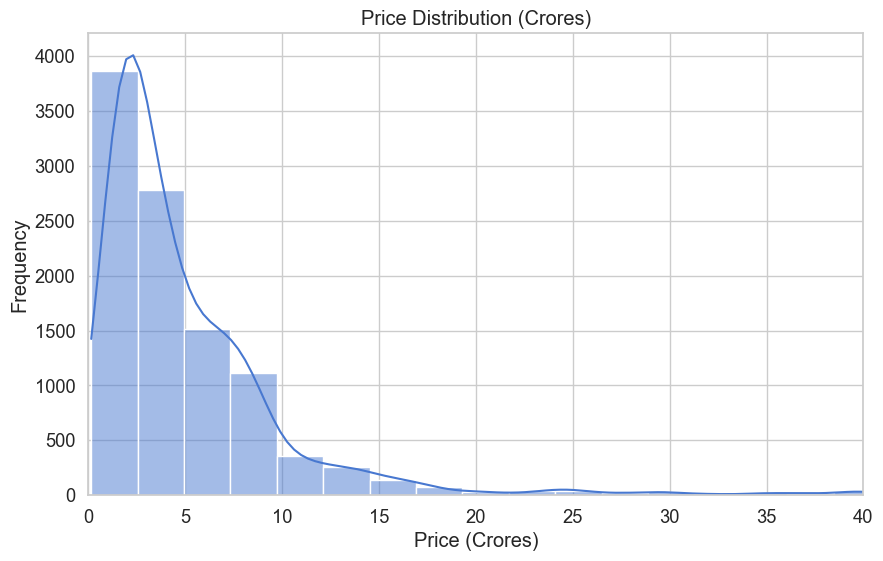

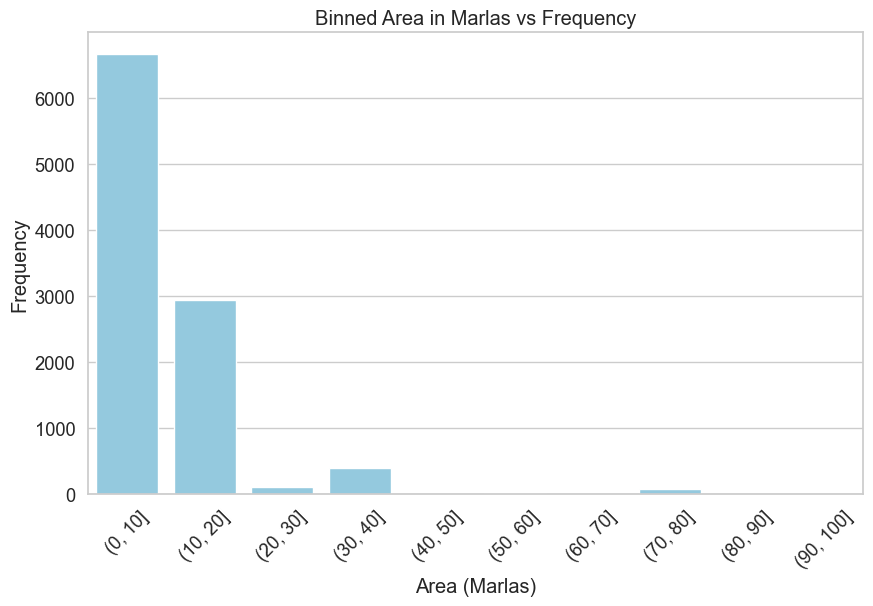

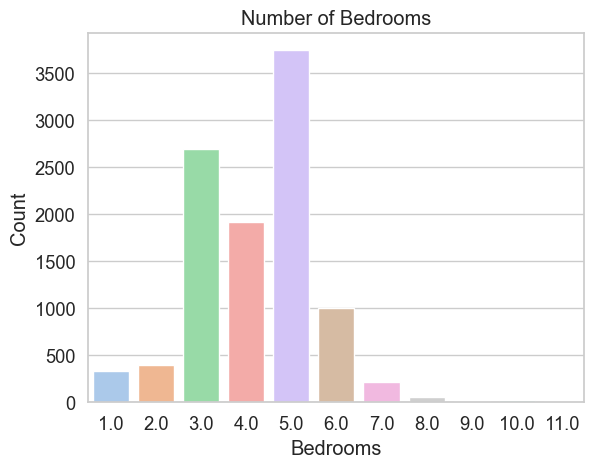

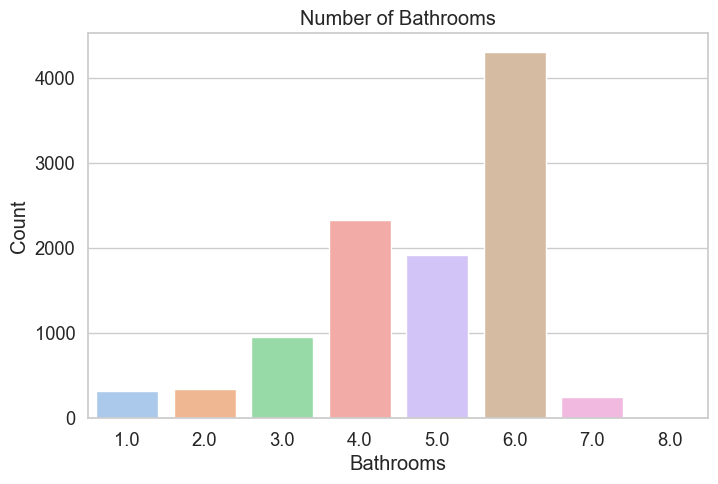

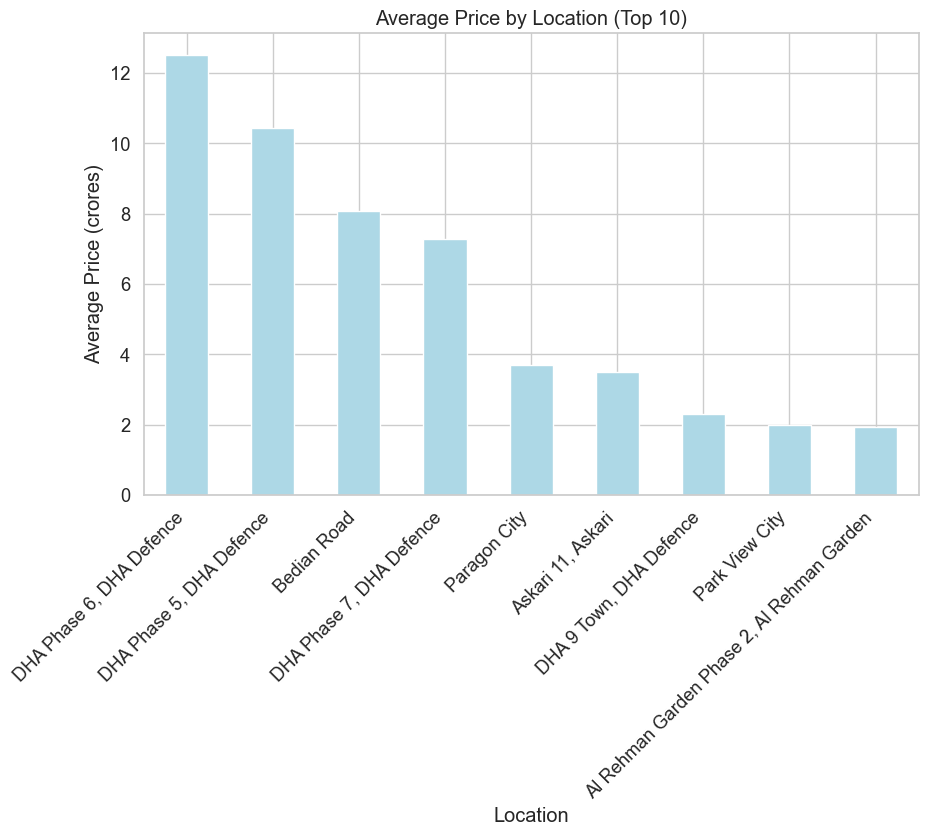

In [8]:
# Price Distribution with Custom X-Axis Range
plt.figure(figsize=(10,6))
sns.histplot(df_cleaned['price_in_crores'], bins=30, kde=True)
plt.title('Price Distribution (Crores)')
plt.xlabel('Price (Crores)')
plt.ylabel('Frequency')
plt.xlim(0, 40)  # Adjust the range as needed
plt.show()

df_filtered = df_cleaned[df_cleaned['area_in_marlas'] > 0]
df_filtered['area_bin'] = pd.cut(df_filtered['area_in_marlas'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
area_counts = df_filtered['area_bin'].value_counts().sort_index().reset_index()
area_counts.columns = ['area_bin', 'frequency']

plt.figure(figsize=(10, 6))
sns.barplot(x='area_bin', y='frequency', data=area_counts, color='skyblue')
plt.title('Binned Area in Marlas vs Frequency')
plt.xlabel('Area (Marlas)')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


# Beds Distribution
sns.countplot(x='beds', data=df_cleaned, palette='pastel')  # Change color here
plt.title('Number of Bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Count')
plt.show()

# Baths Distribution
plt.figure(figsize=(8,5))
sns.countplot(x='baths', data=df_cleaned, palette='pastel')
plt.title('Number of Bathrooms')
plt.xlabel('Bathrooms')
plt.ylabel('Count')
plt.show()

# Average price by location
filtered_locations = df_cleaned.groupby('location_precise').filter(lambda x: len(x) >= 100)
avg_price_by_location = filtered_locations.groupby('location_precise')['price_in_crores'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
avg_price_by_location.plot(kind='bar', color='lightblue')
plt.title("Average Price by Location (Top 10)")
plt.xlabel("Location")
plt.ylabel("Average Price (crores)")

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

plt.show()

### Correlation Analysis

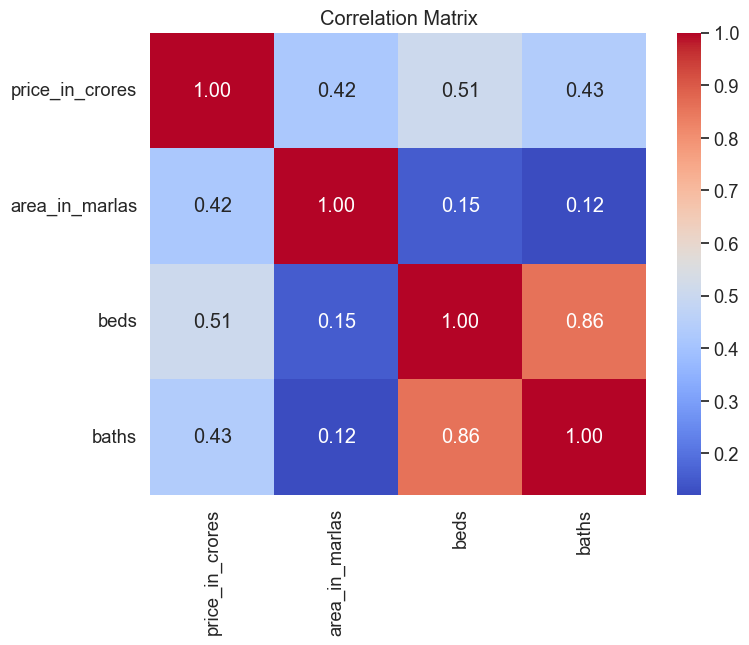

In [9]:
# correlation matrix -- heatmap
plt.figure(figsize=(8,6))
corr_matrix = df_cleaned[['price_in_crores', 'area_in_marlas', 'beds', 'baths']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

### Scatter and Box Plots

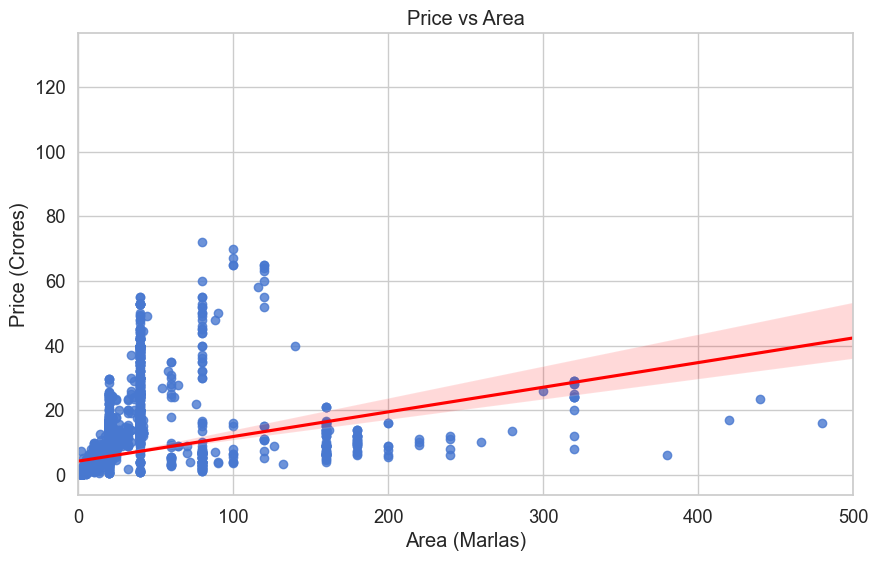

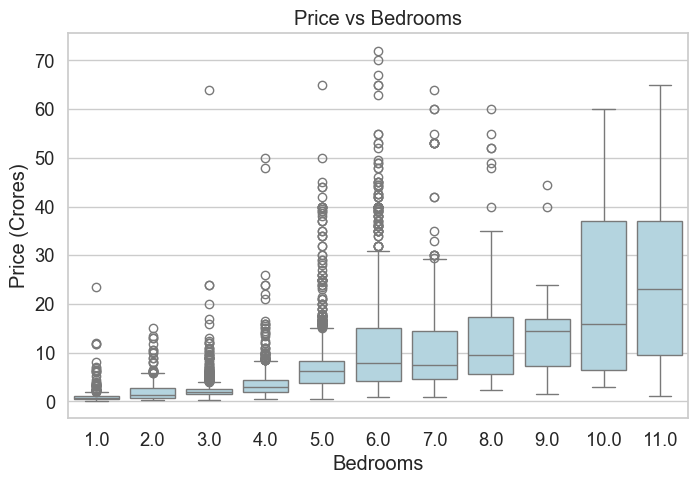

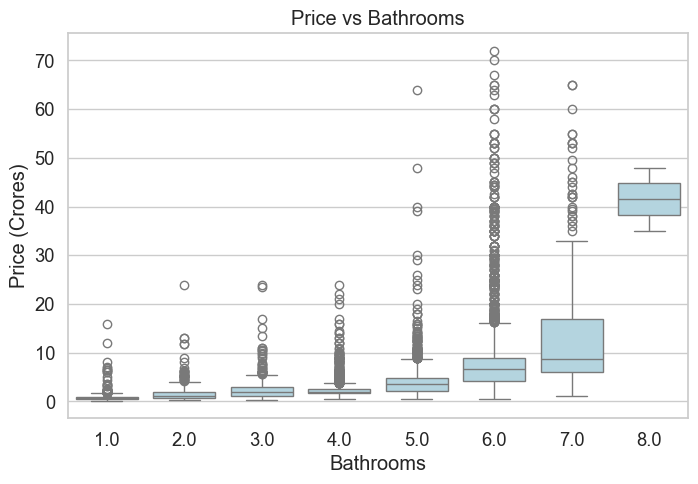

In [10]:
# Price vs Area with Line of Best Fit
plt.figure(figsize=(10, 6))
sns.regplot(x='area_in_marlas', y='price_in_crores', data=df_cleaned, scatter=True, line_kws={'color': 'red'})
plt.title('Price vs Area')
plt.xlabel('Area (Marlas)')
plt.ylabel('Price (Crores)')
plt.xlim(0, 500)
plt.show()

# Price vs Bedrooms
plt.figure(figsize=(8,5))
sns.boxplot(x='beds', y='price_in_crores', data=df_cleaned, color='lightblue')
plt.title('Price vs Bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Price (Crores)')
plt.show()

# Price vs Bathrooms
plt.figure(figsize=(8,5))
sns.boxplot(x='baths', y='price_in_crores', data=df_cleaned, color='lightblue')
plt.title('Price vs Bathrooms')
plt.xlabel('Bathrooms')
plt.ylabel('Price (Crores)')
plt.show()

#  Creating a heatmap centered around Lahore, representing property prices in crores.

In [13]:
avg_prices = df_cleaned.groupby(['latitude', 'longitude'])['price_in_crores'].mean().reset_index()

heat_data = [
    [row['latitude'], row['longitude'], row['price_in_crores']]
    for index, row in avg_prices.iterrows()
]
m = folium.Map(location=[31.5204, 74.3587], zoom_start=10)
HeatMap(heat_data, radius=15, max_zoom=13).add_to(m)
from IPython.display import display
display(m)

## Research Question 1: What factors significantly influence property prices in Lahore?

In [14]:
le = LabelEncoder()
df_cleaned['type'] = le.fit_transform(df_cleaned['type'])

df_cleaned = pd.get_dummies(df_cleaned, columns=['location'], prefix='General-Location', drop_first=False)
df_cleaned = df_cleaned.astype({col: 'int32' for col in df_cleaned.columns if col.startswith('General-Location_')})
df_cleaned = pd.get_dummies(df_cleaned, columns=['location_precise'], prefix='Precise-Location', drop_first=False)
df_cleaned = df_cleaned.astype({col: 'int32' for col in df_cleaned.columns if col.startswith('Precise-Location_')})

In [15]:
df_cleaned['beds+baths'] = df_cleaned['baths'] + df_cleaned['beds']

X = df_cleaned.drop(columns=['price_in_crores'])  # Features

y = df_cleaned['price_in_crores']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.drop(columns=['latitude', 'longitude'])
X_test = X_test.drop(columns=['latitude', 'longitude'])


X_train = X_train.drop(columns=['baths', 'beds','area'])
X_test = X_test.drop(columns=['baths', 'beds', 'area'])


In [16]:
# #dropping irrelevant columns
X_train = X_train.drop(columns=['description'])
X_test = X_test.drop(columns=['description'])
X_train = X_train.drop(columns=['purpose'])
X_test = X_test.drop(columns=['purpose'])

In [17]:
X_train.head()

,type,area_in_marlas,General-Location_Abdalians Cooperative Housing Society,General-Location_Afzal Park,General-Location_Agrics Town,General-Location_Ahbab Colony,General-Location_Ahmad Avenue,General-Location_Ahmad Housing Society,General-Location_Ahmed Colony,General-Location_Airline Housing Society,...,"Precise-Location_Zafar Ali Road, Gulberg","Precise-Location_Zahoor Elahi Road, Gulberg","Precise-Location_Zain Residencia, Ferozepur Road",Precise-Location_Zaitoon City,"Precise-Location_Zameen Aurum, Gulberg 3 - Block L, Gulberg 3, Gulberg","Precise-Location_Zameen Opal, Land Breeze Housing Society","Precise-Location_Zarrar Shaheed Road, Cantt",Precise-Location_Zubaida Park,"Precise-Location_Zubair Colony, Islam Nagar",beds+baths
2179,2,20.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11.0
404,2,10.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10.0
3177,1,14.9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.0
1784,2,5.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8.0
575,2,20.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11.0


### Training ML models ###

In [18]:
def print_metrics(y_test, preds):
    mape = mean_absolute_percentage_error(y_test, preds)
    print(f"Mean Absolute Percentage Error (MAPE): {mape}")

    mae = mean_absolute_error(y_test, preds)
    print(f"Mean Absolute Error (MAE): {mae}")

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    r2 = r2_score(y_test, preds)
    print(f"R-squared (R²): {r2}")

    evs = explained_variance_score(y_test, preds)
    print(f"Explained Variance Score: {evs}")

models = {
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "K-Nearest Neighbors Regressor": KNeighborsRegressor(),
    "XGBoost Regressor": xgb.XGBRegressor(objective='reg:squarederror'),
}

for model_name, model in models.items():
    print(model_name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print_metrics(y_test, y_pred)
    print("\n")

Decision Tree Regressor
Mean Absolute Percentage Error (MAPE): 0.172274994864039
Mean Absolute Error (MAE): 1.0201658788533683
Root Mean Squared Error (RMSE): 2.432752020139225
R-squared (R²): 0.867596028137673
Explained Variance Score: 0.8675963057738412


Random Forest Regressor
Mean Absolute Percentage Error (MAPE): 0.16427624389995654
Mean Absolute Error (MAE): 1.0074357272817596
Root Mean Squared Error (RMSE): 2.418438515746442
R-squared (R²): 0.8691494865725724
Explained Variance Score: 0.8692233604467718


K-Nearest Neighbors Regressor
Mean Absolute Percentage Error (MAPE): 0.20966934735796397
Mean Absolute Error (MAE): 1.2407332660902979
Root Mean Squared Error (RMSE): 3.0759578260178944
R-squared (R²): 0.7883266988876182
Explained Variance Score: 0.7893260674974486


XGBoost Regressor
Mean Absolute Percentage Error (MAPE): 0.19544181156614718
Mean Absolute Error (MAE): 1.0542151246501894
Root Mean Squared Error (RMSE): 2.374149051282364
R-squared (R²): 0.8738981983976304
Expla

In [ ]:
# Hyperparameter tuning
# Feel free to skip this cell, with take 6 mins

xgb_model = xgb.XGBRegressor()

params_grid = {
    'max_depth': [20, 50, 75],
    'learning_rate': [0.1, 0.5, 1],
    'n_estimators': [50, 75, 100],
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=params_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}") ## trained my model using these parameters

In [26]:
# Convert datasets to DMatrix
train_dmatrix = xgb.DMatrix(data=X_train, label=y_train)
test_dmatrix = xgb.DMatrix(data=X_test, label=y_test)

# Model parameters
params = {
    "objective": "reg:squarederror",  # Regression objective
    "max_depth": 50,
    "learning_rate": 0.1,
    "n_estimators": 50,
}

# Training the model
model = xgb.train(params, train_dmatrix, num_boost_round=100)

# Predictions
preds = model.predict(test_dmatrix)

#Calculating Error metrics
print("XGB")
print_metrics(y_test, preds)

XGB
Mean Absolute Percentage Error (MAPE): 0.16532820819065688
Mean Absolute Error (MAE): 1.0563520514496008
Root Mean Squared Error (RMSE): 2.56731713171731
R-squared (R²): 0.8525433485901768
Explained Variance Score: 0.8525483495358446


### While Random Forest was statistically the best performing model, we found that it lacked explainability, and it gave undue importance to certain features, We found XGB to be the best well-rounded model. ###

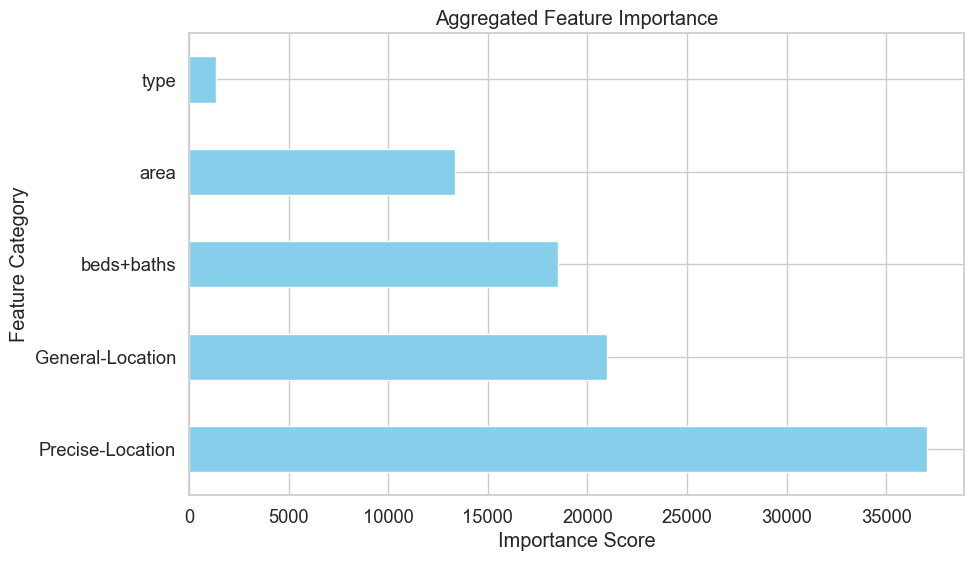

In [27]:
#Calculating Error metrics

feature_importances = model.get_score(importance_type='weight')
# Convert feature importances into a DataFrame
importance_df = pd.DataFrame(list(feature_importances.items()), columns=['Feature', 'Importance'])


importance_df['Category'] = importance_df['Feature'].str.split('_').str[0]  # Extract category
category_importance = (
    importance_df.groupby('Category')['Importance']
    .sum()
    .sort_values(ascending=False)
)

# Plot aggregated feature importance
plt.figure(figsize=(10, 6))
category_importance.head(10).plot(kind='barh', color='skyblue', title="Aggregated Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature Category")
plt.show()


The plot above illustrates the feature importance scores obtained from the trained XGBoost model. Feature importance represents how much each variable contributes to the predictive power of the model. The higher the score, the more significant the feature in influencing property prices.

The analysis indicates that property location is the primary driver of property prices in Lahore. Other features, such as the Total Area, Total number of beds and baths and property type may affect price but to a lesser degree.

## Property Price Prediction Inference ##

In [28]:
def predict_price(type1, area, num_beds_baths, location, location_p):
    input_data = {
        'area_in_marlas': area,
        'beds+baths': num_beds_baths,
    }
    input_data['type'] = 1 if type1 == "Rent" else 2
    for loc in locations:
        input_data[f'General-Location_{loc}'] = 1 if loc == location else 0
    for loc in locations_p:
        input_data[f'Precise-Location_{loc}'] = 1 if loc == location_p else 0
    input_df = pd.DataFrame([input_data], columns=X_train.columns)
    input_dmatrix = xgb.DMatrix(input_df)
    prediction = model.predict(input_dmatrix)
    return prediction[0]


location_columns = [col for col in df_cleaned.columns if col.startswith('General')]
locations = [col.replace('General-Location_', '') for col in location_columns]

location_columns = [col for col in df_cleaned.columns if col.startswith('Precise')]
locations_p = [col.replace('Precise-Location_', '') for col in location_columns]

css = """
.center-aligned {
    text-align: center;
}
.footer {
    font-size: 12px;
    text-align: center;
    color: grey;
}
"""

with gr.Blocks(css=css) as demo:
    gr.Markdown("# Property Price Prediction", elem_classes=["center-aligned"])
    
    type_options = ['Sale', 'Rent']
    
    with gr.Row():
        type_input = gr.Dropdown(choices=type_options, label="Property Type")
        area_input = gr.Slider(minimum=0, maximum=500, step = 1, label="Area (in Marlas)")
        num_beds_baths_input = gr.Slider(minimum=1, maximum=100, step = 1, label="Baths + Bedrooms")
    
    with gr.Row():
        location_input = gr.Dropdown(
            label="Select a General Location", 
            choices=locations,
            value=locations[0],
            interactive=True
        )
        precise_location_input = gr.Dropdown(
            label="Select a Precise Location", 
            choices=locations_p,
            value=locations_p[0],
            interactive=True
        )

    with gr.Row():
        output = gr.Textbox(label="Predicted Price (in Crores)")

    gr.Button("Predict", elem_classes=["center-aligned"]).click(
        predict_price, 
        inputs=[type_input, area_input, num_beds_baths_input, location_input, precise_location_input], 
        outputs=output
    )

    gr.HTML("<div class='footer'>© 2024 Property Price Prediction. All rights reserved.</div>", elem_classes=["center-aligned"])

    demo.launch(quiet=True)

# Research Question 2: How do properties vary across different neighbourhood?

In [29]:
df = pd.read_csv("cleaned_properties.csv")

In [30]:

# Remove invalid rows
df = df.dropna(subset=['price_in_crores', 'area_in_marlas', 'location'])

# Calculating price per marla
df['price_per_marla'] = df['price_in_crores'] * 100 / df['area_in_marlas']

# Remove rows with infinite or NaN values
df = df.replace([np.inf, -np.inf], np.nan).dropna()

# Frequency filter to avoid outliers
location_freq = df['location'].value_counts()
min_frequency = 50
filtered_locations = location_freq[location_freq >= min_frequency].index
df = df[df['location'].isin(filtered_locations)]

# Aggregating Data by Location
location_summary = df.groupby('location').agg({
    'price_per_marla': 'mean',
    'area_in_marlas': 'mean',
    'price_in_crores': 'mean',
    'type': 'count',
    'beds': 'mean',
    'baths': 'mean'
}).rename(columns={'type': 'listing_count'})

location_summary.reset_index(inplace=True)

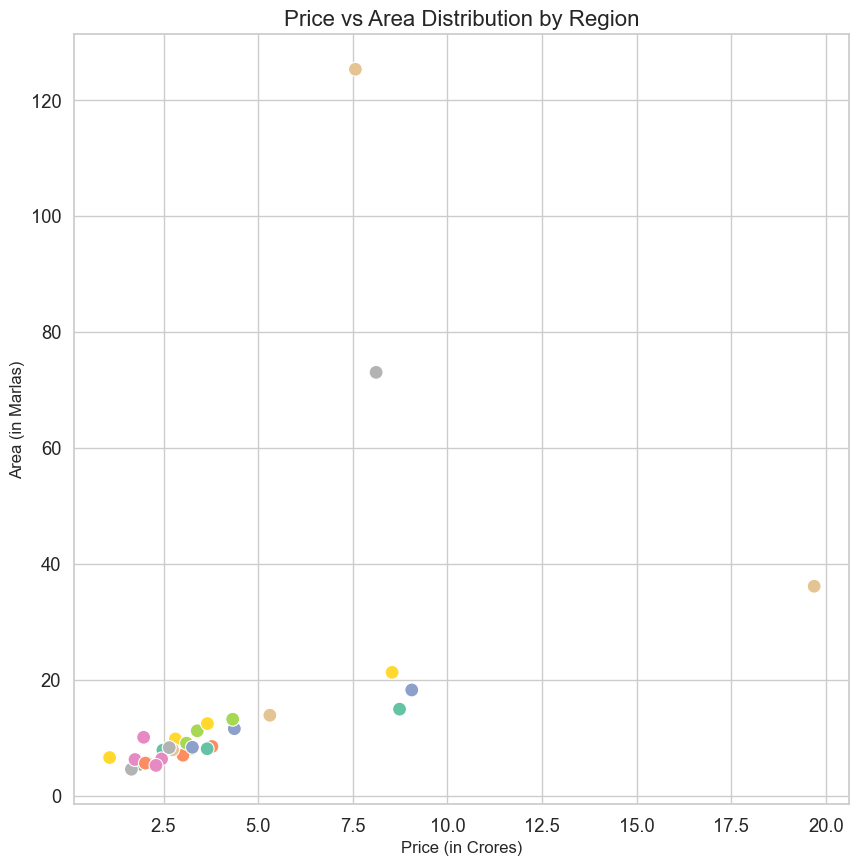

In [31]:

plt.figure(figsize=(10, 10))
sns.scatterplot(data=location_summary, x='price_in_crores', y='area_in_marlas', hue='location', palette='Set2', s=100, legend = False)
plt.title('Price vs Area Distribution by Region', fontsize=16)
plt.xlabel('Price (in Crores)', fontsize=12)
plt.ylabel('Area (in Marlas)', fontsize=12)
# plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')  # Moving legend outside
plt.grid(True)
plt.show()

# Research Question 3: What regions in Lahore offer the best opportunities for buyers and sellers?

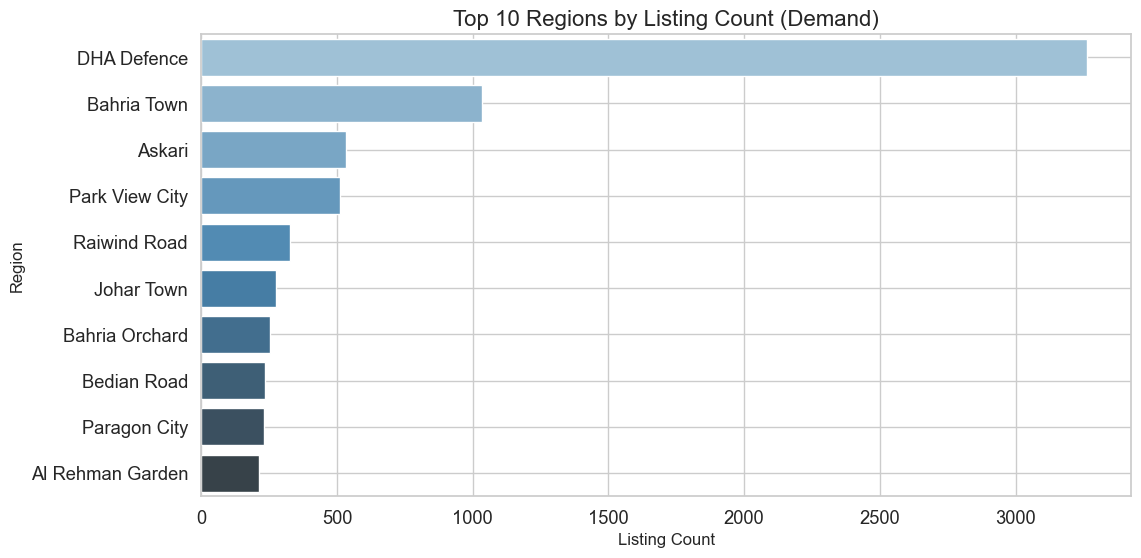

In [32]:
# 1. Top 10 Regions by Listing Count (High Demand)
top_regions_by_demand = location_summary.sort_values(by='listing_count', ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x='listing_count', y='location', data=top_regions_by_demand, palette='Blues_d')
plt.title('Top 10 Regions by Listing Count (Demand)', fontsize=16)
plt.xlabel('Listing Count', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.grid(True)
plt.show()


This analysis identifies the top 10 regions in Lahore with the highest listing counts, indicating areas with the greatest demand in the real estate market.
Findings show that DHA Defence and Bahria Town are the regions with a strong market activity and high demand for properties.

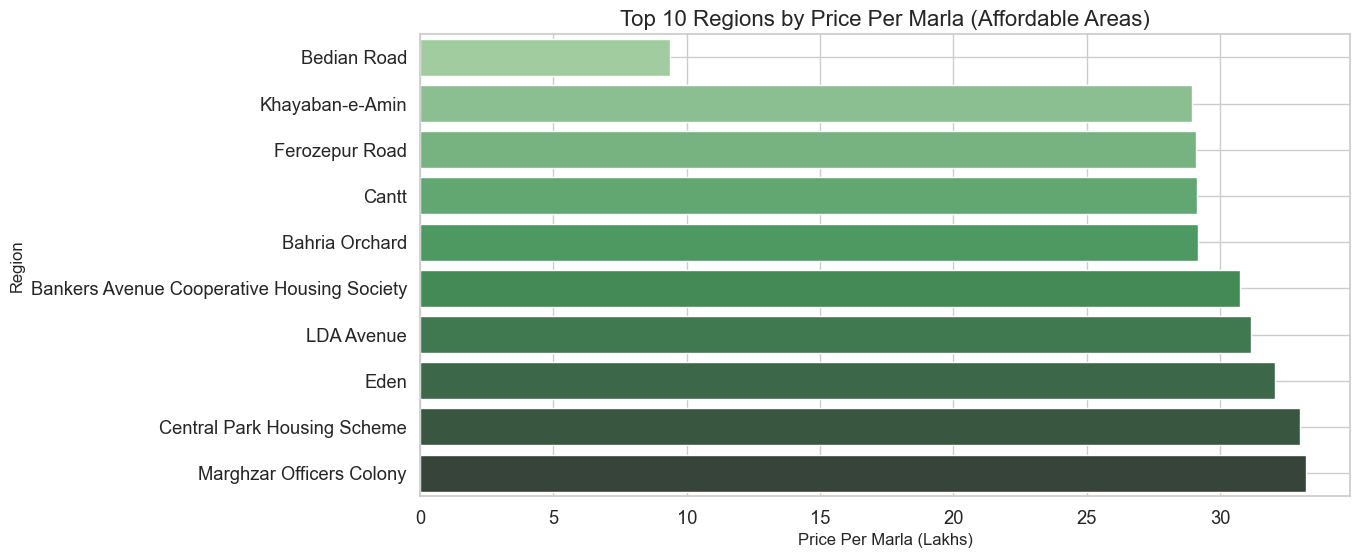

In [33]:
# 2. Top 10 Regions by Price Per Marla (Affordable Areas)
top_regions_by_price = location_summary.sort_values(by='price_per_marla', ascending=True).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x='price_per_marla', y='location', data=top_regions_by_price, palette='Greens_d')
plt.title('Top 10 Regions by Price Per Marla (Affordable Areas)', fontsize=16)
plt.xlabel('Price Per Marla (Lakhs)', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.grid(True)
plt.show()

This analysis identifies the top 10 most affordable regions in Lahore based on the price per marla (land unit). These areas are particularly attractive to buyers seeking cost-effective options. Bedian Road is the most affordable region, with the lowest price per marla, making it ideal for budget-conscious buyers. Other areas like Khayaban-e-Amin and Ferozpur road are also affordable options but Bedian Road is ahead by a significant margin.

Overall, both the plots suggest that areas like DHA Defence and Bahria Town are optimal for sellers looking to capitalize on high demand, while regions such as Bedian Road are ideal for buyers seeking affordability. These insights provide a comprehensive understanding of where buyers and sellers can find the most opportunities in Lahore's real estate market.